In [1]:
from numpy.matrixlib.defmatrix import matrix
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns
import VITAE
from VITAE.utils import load_data
import tensorflow as tf
import random
import os
from matplotlib import pyplot as plt


def create_heatmap_matrix(pi):
    """Create heatmap matrix
    @pi: numpy array contains pi weights"""
    matrix = np.zeros((5, 5))
    matrix[np.triu_indices(5)] = pi
    mask = np.tril(np.ones_like(matrix), k=-1)
    return matrix, mask


def reset_random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   random.seed(seed)

In [2]:
data = load_data("./data/", file_name="dentate_withdays")
labels = pd.DataFrame({'Grouping': data['grouping']}, index = data['cell_ids'])
labels['Grouping'] = labels['Grouping'].astype("category")
genes = pd.DataFrame({'gene_names': data['gene_names']}, index = data['gene_names'])
dd = sc.AnnData(X = data['count'].copy(), obs = labels, var = genes)
dd.layers['counts'] = dd.X.copy()
dd.obs['days'] = data['covariates']
dd.obs['days2'] = data['covariates']

In [3]:
data = load_data("./data/", file_name="dentate_withdays")
labels = pd.DataFrame({'Grouping': data['grouping']}, index = data['cell_ids'])
labels['Grouping'] = labels['Grouping'].astype("category")
genes = pd.DataFrame({'gene_names': data['gene_names']}, index = data['gene_names'])
dd = sc.AnnData(X = data['count'].copy(), obs = labels, var = genes)
dd.layers['counts'] = dd.X.copy()
dd.obs['days'] = data['covariates']
sc.pp.normalize_total(dd, target_sum=1e4)
sc.pp.log1p(dd)
sc.pp.highly_variable_genes(dd, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(dd, max_value=10)
sc.tl.pca(dd, svd_solver='arpack')
sc.pp.neighbors(dd, n_neighbors=10, n_pcs=40)
sc.tl.leiden(dd, resolution = 0.4)
sc.tl.umap(dd)

reset_random_seeds(400)
tf.keras.backend.clear_session() 
model = VITAE.VITAE(adata = dd, pi_covariates='days', model_type = 'Gaussian')
model.pre_train() 
model.init_latent_space(cluster_label= 'leiden', res = 0.4, pilayer=True) 
model.train()

 82/200 [===========>..................] - ETA: 19sBest Epoch: 70. Best Metric: 43.342094.
Early stopping.
Pretrain Done.
Initial clustering labels saved as 'vitae_init_clustering' in self.adata.obs.
Warmup:0
 60/200 [========>.....................] - ETA: 43sBest Epoch: 48. Best Metric: 72.271790.
Early stopping.
Training Done!


Computing posterior estimations over mini-batches.
126/126 [==============================] - 1s 6ms/step
New clustering labels saved as 'vitae_new_clustering' in self.adata.obs.


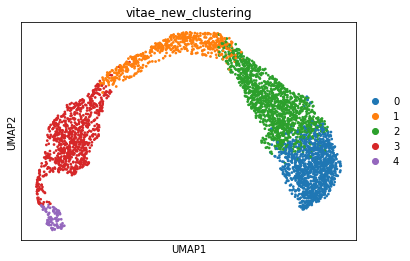

In [5]:
model.posterior_estimation()
model.visualize_latent(color = ['vitae_new_clustering'], method = "UMAP")

C:\Users\Alan\AppData\Local\Temp/ipykernel_11536/835270506.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


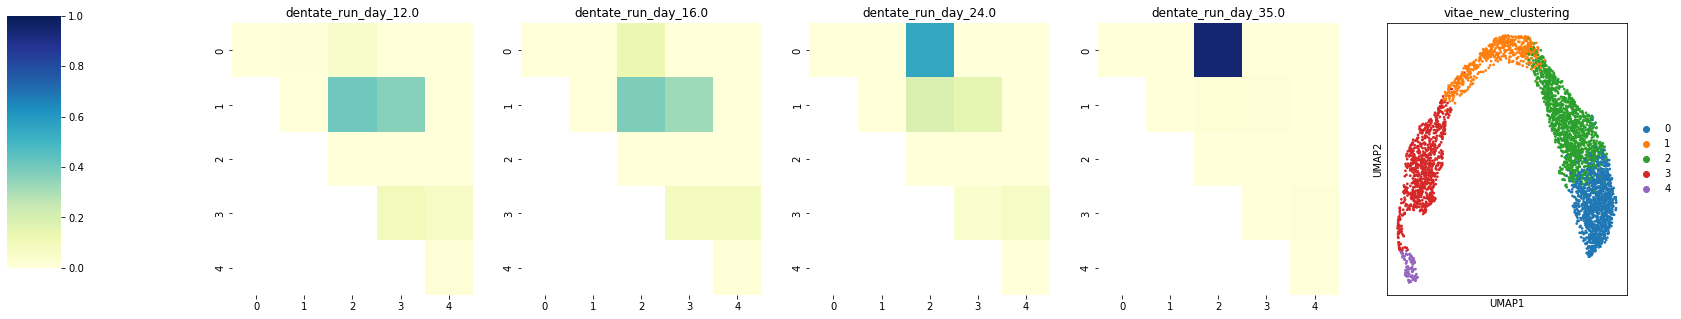

In [6]:
import seaborn as sns
f, axes = plt.subplots(1, 5, figsize=(25,5))
cbar_ax = f.add_axes([0, 0.2, .03, 0.7])
idx = 0
for x in dd.obs['days'].sort_values().unique():
    matrix, mask = model.output_pi(x)
    sns.heatmap(matrix, vmin=0, vmax=1, cmap="YlGnBu", mask=mask, ax=axes[idx], cbar_ax=cbar_ax)
    axes[idx].set_title(f'dentate_run_day_{x}')
    idx += 1
sc.pl.umap(model._adata, color='vitae_new_clustering', show=False, ax=axes[-1])
f.show()